<h1 style="text-align: center;">Deep Learning<br><br>Handwritten Digits Recognition with CNN<br><br>MNIST Data<br><h1>

# Dataset Info

The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.

The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. The original creators of the database keep a list of some of the methods tested on it. In their original paper, they use a support-vector machine to get an error rate of 0.8%.

![3Dto2D](https://upload.wikimedia.org/wikipedia/commons/thumb/2/27/MnistExamples.png/320px-MnistExamples.png)

In [4]:
try:
    import jupyter_black
    jupyter_black.load()
except ImportError:
    print("You can safely ignore this message.")

You can safely ignore this message.


In [5]:
import os

# Set TF log level to ignore INFOs.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 6)

sns.set_style("whitegrid")
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option("display.max_columns", None)

np.set_printoptions(suppress=True)

In [7]:
import tensorflow as tf
from tensorflow import keras

if tf.config.list_physical_devices("GPU"):
    print("GPU support is enabled for this session.")
else:
    print("CPU will be used for this session.")

GPU support is enabled for this session.


In [8]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) `tensorflow` random seed
# 3) `python` random seed
SEED = 42
keras.utils.set_random_seed(SEED)

# This will make TensorFlow ops as deterministic as possible, but it will
# affect the overall performance, so it's not enabled by default.
# `enable_op_determinism()` is introduced in TensorFlow 2.9.
tf.config.experimental.enable_op_determinism()

In [9]:
if tf.config.list_physical_devices("GPU"):
    !nvidia-smi

Thu Apr 25 20:21:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.09                 Driver Version: 546.09       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   64C    P5              11W /  80W |    387MiB /  6144MiB |     34%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Recognizing and Understanding Data

In [10]:
from tensorflow.keras.datasets.mnist import load_data  # To load the MNIST digit dataset

(X_train, y_train), (X_test, y_test) = load_data()  # Loading data

In [11]:
print(f"There are {len(X_train)} images in the training dataset")
print(f"There are {len(X_test)} images in the test dataset")

There are 60000 images in the training dataset
There are 10000 images in the test dataset


In [12]:
# Checking the shape of one image
X_train[99].shape

(28, 28)

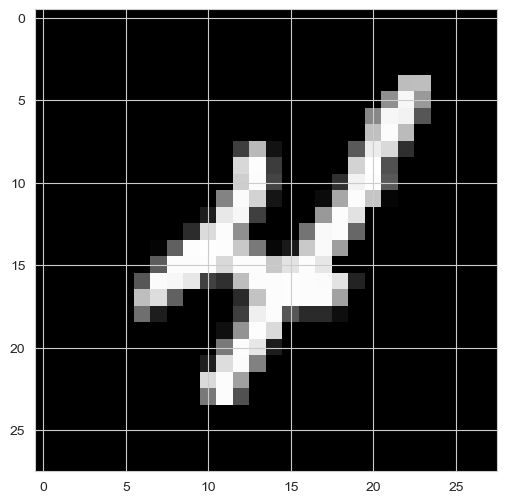

In [13]:
plt.imshow(X_train[9], cmap="gray")

<Axes: >

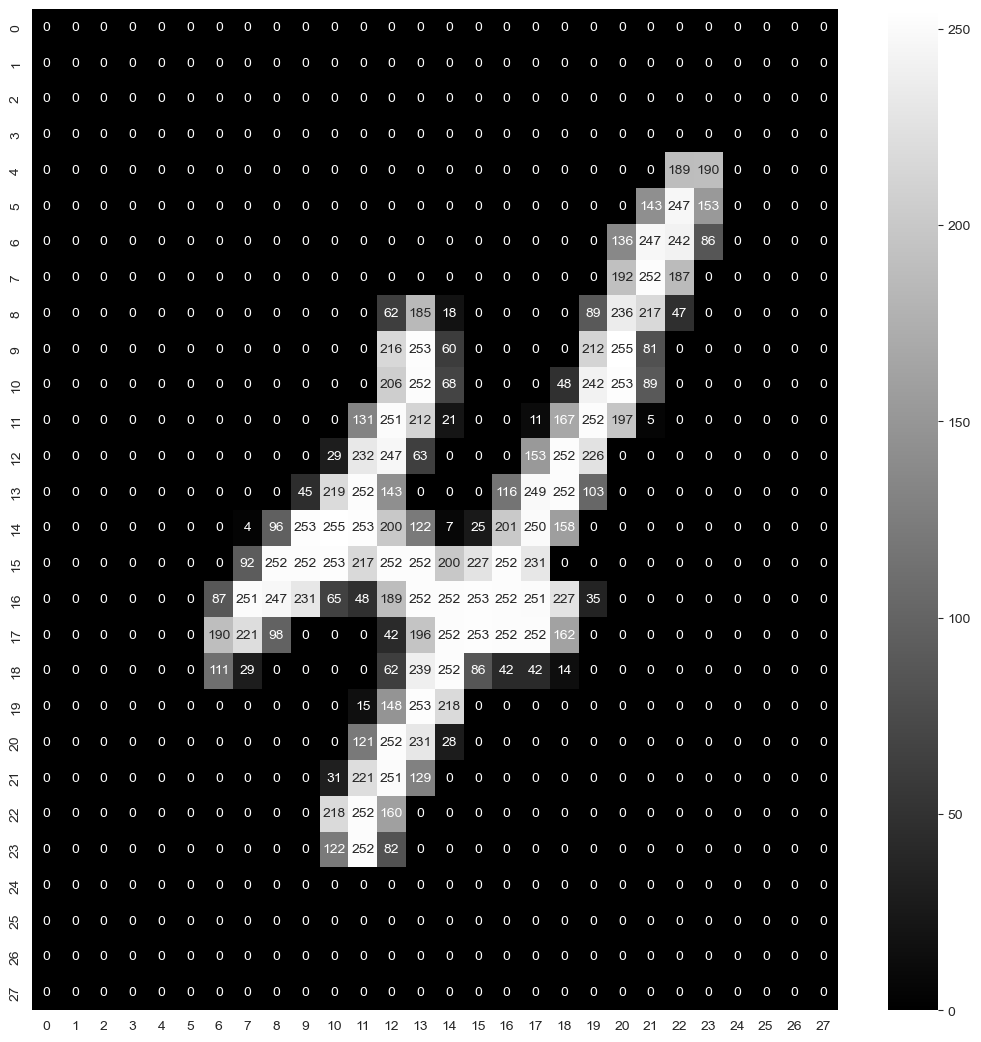

In [14]:
plt.figure(figsize=(13, 13))
sns.heatmap(X_train[9], annot=True, cmap="gray", fmt=".3g")

In [15]:
len(X_train[24999])

28

In [16]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [17]:
y_train[9]

4

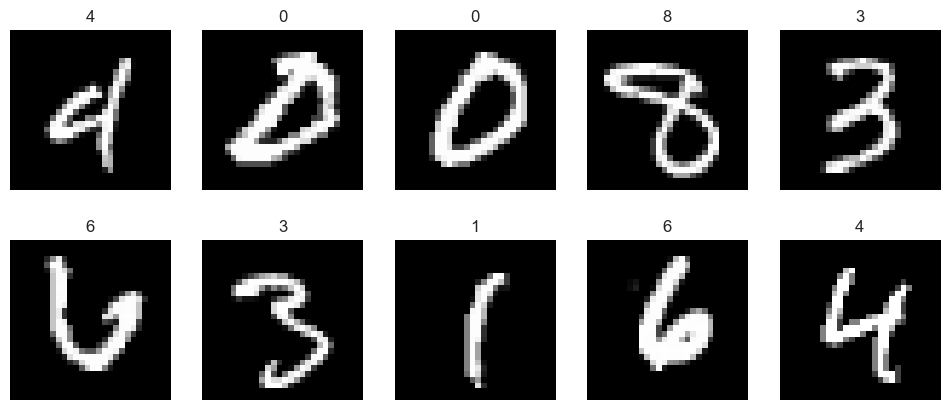

In [18]:
f, axes = plt.subplots(2, 5, figsize=(12, 5))

for ax in axes.ravel():
    idx = np.random.randint(0, len(X_train))
    ax.axis("off")
    ax.set_title(y_train[idx])
    ax.imshow(X_train[idx], cmap="gray")
plt.show()

# Data Preprocessing

In [19]:
X_train[342].min()

0

In [20]:
X_train[9].max()

255

In [21]:
# Normalize image pixels
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

In [22]:
X_train[9].min()

0.0

In [23]:
X_train[9].max()

1.0

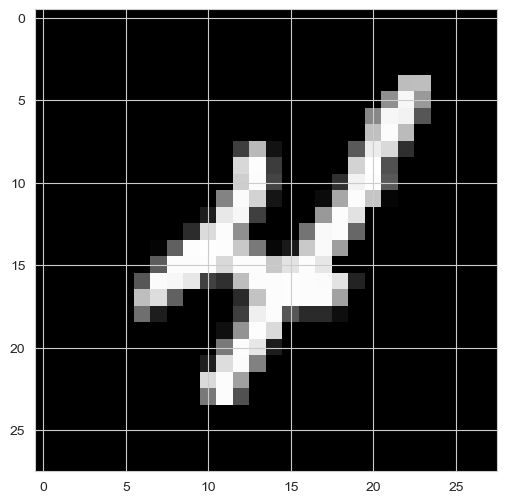

In [24]:
plt.imshow(X_train[9], cmap="gray")
plt.show()

In [25]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [26]:
np.expand_dims(X_train, 3).shape

(60000, 28, 28, 1)

In [27]:
X_train = np.expand_dims(X_train, 3)
X_test = np.expand_dims(X_test, 3)

In [28]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [29]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [30]:
y_train.shape

(60000,)

In [31]:
from tensorflow.keras.utils import to_categorical

In [32]:
Y_train = to_categorical(y_train, 10)
Y_test = to_categorical(y_test, 10)
Y_train.shape

(60000, 10)

In [33]:
y_train[9]

4

In [34]:
Y_train[9]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

# Modeling

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [36]:
model = Sequential()

model.add(
    Conv2D(filters=32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation="relu")
)  # stride = 1, padding = valid

model.add(MaxPool2D(pool_size=(2, 2)))  # stride = pool size, padding = valid

model.add(Flatten())

model.add(Dense(128, activation="relu"))

model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

**A sample example showing the conversion of 3D data to 2D**
![3Dto2D](https://dphi-courses.s3.ap-south-1.amazonaws.com/Deep+Learning+Bootcamp/3D+to++2D.png)

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
__________________________________________________

Number of parameter in CL

$((n \times m \times l)+1) \times k$

$n \times m$*: filter shape*

$l$*: number of input channel (feature maps as input)*

$k$*: number of output channel (feature maps as output)*

In [38]:
((3 * 3 * 1) + 1) * 32

320

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
early_stop = EarlyStopping(
    monitor="val_accuracy", mode="max", patience=4, restore_best_weights=True
)

In [41]:
model.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_test, Y_test),
    callbacks=[early_stop],
)

Epoch 1/20


1875/1875 [==============================] - 14s 4ms/step - loss: 0.1502 - accuracy: 0.9560 - val_loss: 0.0709 - val_accuracy: 0.9778
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0524 - accuracy: 0.9837 - val_loss: 0.0567 - val_accuracy: 0.9796
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0341 - accuracy: 0.9893 - val_loss: 0.0426 - val_accuracy: 0.9851
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0234 - accuracy: 0.9923 - val_loss: 0.0436 - val_accuracy: 0.9859
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.0538 - val_accuracy: 0.9837
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0105 - accuracy: 0.9966 - val_loss: 0.0474 - val_accuracy: 0.9852
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.0493 - val_accuracy: 0.9861
Ep

In [42]:
X_train.shape

(60000, 28, 28, 1)

In [43]:
Y_train.shape

(60000, 10)

In [44]:
model.metrics_names

['loss', 'accuracy']

In [45]:
# here we have accuracy not recall bec we have defined metrics=["accuracy"] in the model above
summary = pd.DataFrame(model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy
0,0.150,0.956,0.071,0.978
1,0.052,0.984,0.057,0.980
2,0.034,0.989,0.043,0.985
3,0.023,0.992,0.044,0.986
4,0.014,0.995,0.054,0.984


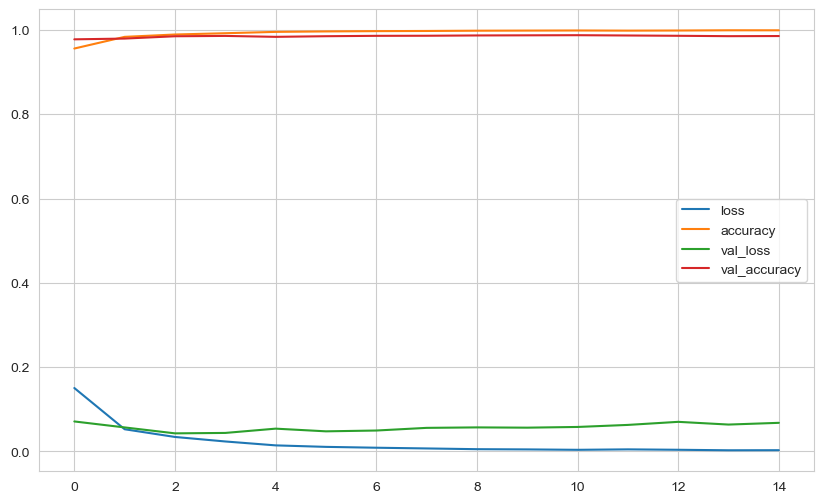

In [46]:
summary.plot();

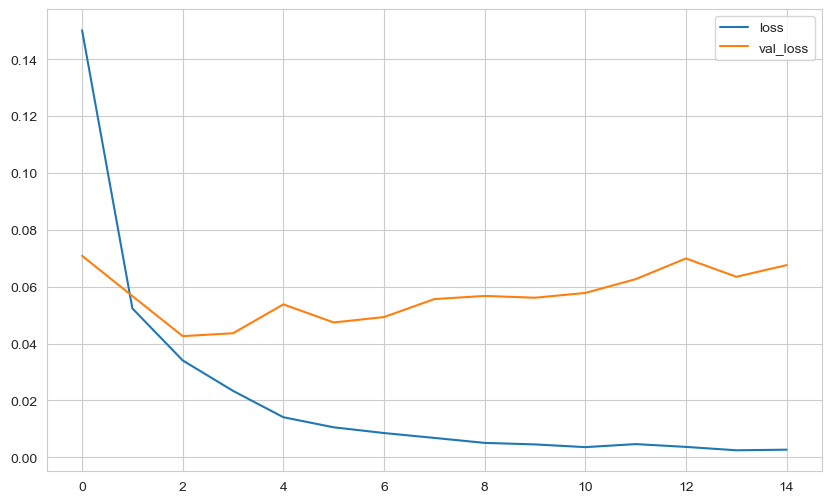

In [47]:
summary[["loss", "val_loss"]].plot();

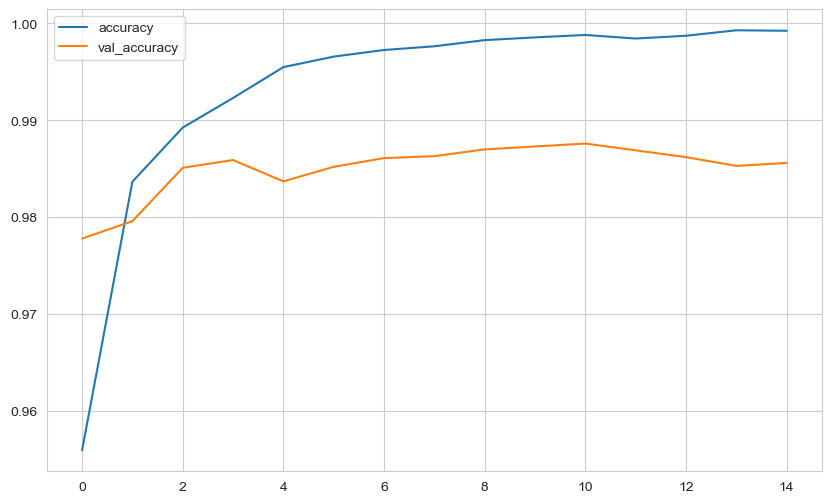

In [48]:
summary[["accuracy", "val_accuracy"]].plot();

# Evaluation on Test Data

In [49]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    multilabel_confusion_matrix,
)

In [50]:
# By default 1st=loss, 2nd=accuracy
model.evaluate(X_test, Y_test)

 71/313 [=====>........................] - ETA: 0s - loss: 0.0823 - accuracy: 0.9824

313/313 [==============================] - 1s 3ms/step - loss: 0.0578 - accuracy: 0.9876


[0.05782245472073555, 0.9876000285148621]

In [51]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.05782245472073555
Test accuracy: 0.9876000285148621


In [52]:
# probability matrix
pred_prob = model.predict(X_test)
pred_prob

313/313 [==============================] - 1s 2ms/step


array([[0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.9999995, 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [53]:
pred_prob.shape

(10000, 10)

In [54]:
# 7th is 1, so this is 7, binary form
pred_prob[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [55]:
np.argmax(pred_prob[0])

7

In [56]:
# predicted results in decimal form
y_pred = np.argmax(pred_prob, axis=1)
y_pred

array([7, 2, 1, ..., 4, 5, 6], dtype=int64)

In [57]:
y_pred.shape

(10000,)

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.97      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.99      0.98       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [59]:
# we can see that the model has difficulty in differentiating 5 and 3
print(confusion_matrix(y_test, y_pred))

[[ 976    1    1    0    0    0    1    1    0    0]
 [   0 1130    1    1    0    0    1    1    1    0]
 [   2    2 1015    0    2    0    1    6    4    0]
 [   0    0    1 1000    0    3    0    2    3    1]
 [   1    0    1    0  975    0    0    0    0    5]
 [   2    0    0   15    0  865    3    0    3    4]
 [   2    2    0    0    1    2  949    0    2    0]
 [   1    1    6    0    1    1    0 1009    1    8]
 [   1    0    1    2    0    1    1    2  961    5]
 [   2    1    0    1    4    1    0    1    3  996]]


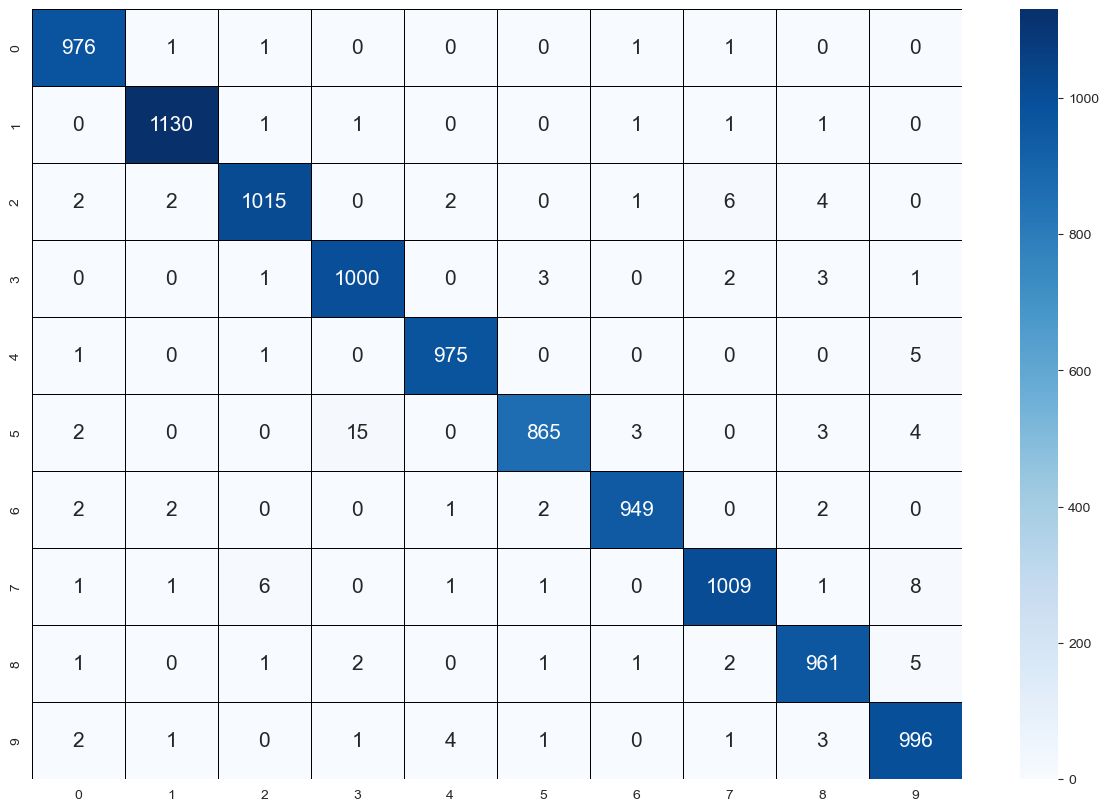

In [60]:
plt.figure(figsize=(15, 10))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    cmap="Blues",
    linewidths=0.5,
    linecolor="black",
    fmt="g",
    annot_kws={"size": 15},
)
plt.show()

In [61]:
# y_test != y_pred
np.not_equal(y_test, y_pred)

array([False, False, False, ..., False, False, False])

In [62]:
# (y_test != y_pred).sum()
np.not_equal(y_test, y_pred).sum()

124

In [63]:
np.equal(y_test, y_pred).sum()

9876

# Prediction

In [64]:
my_number = X_test[3]

In [65]:
my_number.shape

(28, 28, 1)

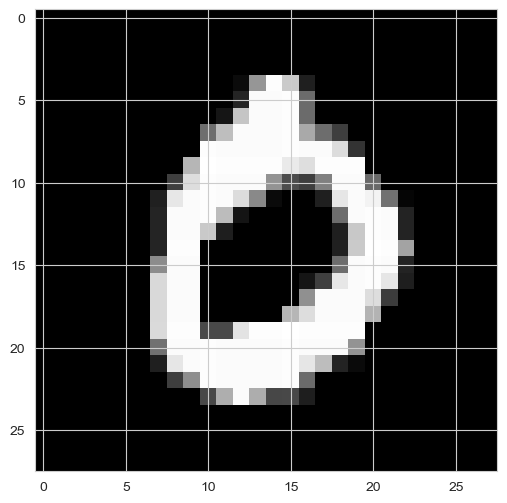

In [66]:
plt.imshow(my_number, cmap="gray")
plt.show()

In [67]:
# before prediction we prepare the data. TF keras expects 4 dimension matrix. so we expand and write the number of data points in the beginning
np.expand_dims(my_number, 0).shape

(1, 28, 28, 1)

In [68]:
pred_prob = model.predict(np.expand_dims(my_number, 0))
pred_prob

1/1 [==============================] - 0s 57ms/step


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [69]:
# SHAPE --> (num_images, width, height, color_channels)
y_pred = np.argmax(pred_prob)
y_pred

0

In [70]:
model.save("cnn-1.h5")

# Using the saved model

In [71]:
model = tf.keras.models.load_model("cnn-1.h5")

In [72]:
# we corrected the dimension
pred = model.predict(np.expand_dims(X_test[24], 0))

1/1 [==============================] - 0s 80ms/step


In [73]:
np.argmax(pred)

4

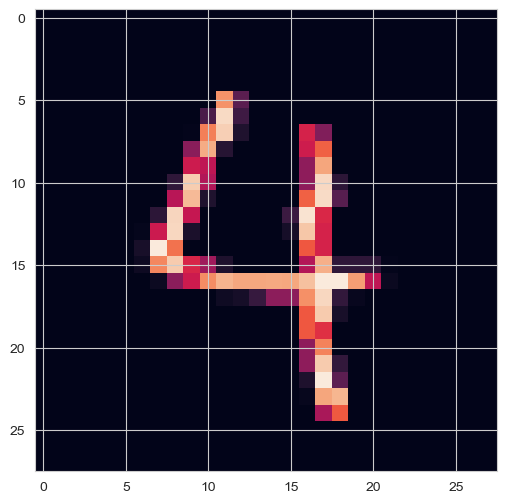

In [74]:
plt.imshow(X_test[24].reshape(28, 28))
plt.show()

END OF THE PROJECT